<a href="https://colab.research.google.com/github/davidmirror-ops/flyte-school/blob/main/03-secure-orchestration/Secure_your_AI_orchestration_platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔐 Secure AI orchestration with Union


First, go to https://signup.union.ai/ to sign up for a Union account. This
will take a few minutes, after which you should be able to go to
https://serverless.union.ai/ to see the Union Serverless dashboard.

In [1]:
!pip install 'flytekit>=1.14.0' 'union>=0.1.54' flytekitplugins-onnxscikitlearn flytekitplugins-pandera>=0.16.0 onnxruntime joblib openai pandas pyarrow scikit-learn numpy

## Login to Union Serverless

In [2]:
!union create login --auth device-flow --serverless

🔐 Configuration saved to /root/.union/config.yaml
To Authenticate, navigate in a browser to the following URL: https://signin-serverless.hosted.unionai.cloud/activate?user_code=KZGXRMCQ
Authentication Pending...
Authentication Pending...
Authentication successful!
Login successful into serverless


## Part 1: 🥒 Pickled Model Attack

In this section we'll exploit a vulnerability of the pickle format to execute a malicous payload

### 🏋️ Training a model

In [3]:
import sys
from functools import partial
from typing import NamedTuple

import joblib
import pandas as pd

import union
from flytekit.deck import MarkdownRenderer
from flytekit.types.file import FlyteFile

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



image = union.ImageSpec.from_env(
    name="ml-security",
    packages=[
        "bandit",
        "flytekit>=1.14.0",
        "joblib",
        "openai",
        "pandas",
        "pyarrow",
        "scikit-learn",
        "union>=0.1.54",
    ],
)

task = partial(
    union.task,
    container_image=image,
    cache=True,
    cache_version="4",
)

ModelOutput = NamedTuple("Output", [("model", FlyteFile), ("accuracy", float)])


@task
def load_data() -> tuple[pd.DataFrame, pd.Series]:
    wine = load_wine()
    X = pd.DataFrame(wine.data, columns=wine.feature_names)
    y = pd.Series(wine.target)
    return X, y


@task
def split_data(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    return train_test_split(X, y, test_size=0.2, random_state=42)


@task
def train_model(X_train: pd.DataFrame, y_train: pd.Series) -> FlyteFile:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    path = "model.joblib"
    joblib.dump(model, path)
    return FlyteFile(path=path)


@task(enable_deck=True)
def evaluate_model(model: FlyteFile, X_test: pd.DataFrame, y_test: pd.Series) -> float:
    with open(model, "rb") as f:
        model = joblib.load(f)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    deck = union.Deck(name="Accuracy Report", html=MarkdownRenderer().to_html(f"# Test accuracy: {accuracy}"))
    union.current_context().decks.insert(0, deck)
    return accuracy


@union.workflow
def wine_classification_workflow() -> ModelOutput:
    X, y = load_data()
    X_train, X_test, y_train, y_test = split_data(X, y)
    model = train_model(X_train, y_train)
    accuracy = evaluate_model(model, X_test, y_test)
    return model, accuracy

15:02:04.740495 WARNING  type_engine.py:1729 - Unsupported Type <class          
                         'pandas.core.series.Series'> found, Flyte will default 
                         to use PickleFile as the transport. Pickle can only be 
                         used to send objects between the exact same version of 
                         Python, and we strongly recommend to use python type   
                         that flyte support.

Create a `UnionRemote` client to run our workflows.

In [4]:
from union.remote import UnionRemote

serverless = UnionRemote()

15:02:09.235222 WARNING  remote.py:293 - Jupyter notebook and interactive task  
                         support is still alpha.

In [5]:
execution = serverless.execute(wine_classification_workflow, inputs={})
execution

15:02:14.050719 WARNING  remote.py:293 - Jupyter notebook and interactive task  
                         support is still alpha.

Image ml-security:ueI4RuSVjkKom8Do5nj06A was not found or has expired.
🐳 Submitting a new build...


15:02:16.068641 WARNING  remote.py:293 - Jupyter notebook and interactive task  
                         support is still alpha.

👍 Build submitted!
⏳ Waiting for build to finish at: https://serverless.union.ai/org/davidmirror-ops/projects/system/domains/production/executions/aqk2j45k9vt627dk4kgv
✅ Build completed in 0:00:41!


Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: aqbsz448d2888t4lzk9g
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: wine_classification_workflow
      version: HzGvvI_svlM171gGWLNsKA
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1740063779
      nanos: 511413000
    updated_at:
      seconds: 1740063779
      nanos: 511413000

Read the model file back into the notebook session:

In [6]:
execution.wait(poll_interval=1)
model_file = execution.outputs["model"]

with open(model_file, "rb") as f:
    model = joblib.load(f)

model

RandomForestClassifier(random_state=42)

Load some features and make predictions:

In [7]:
features, _ = load_data()
predictions = model.predict(features)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

### 🍽️ Serving the model in batch mode

Here we define a simple batch prediction task.

In [8]:
Predictions = NamedTuple("Predictions", [("predictions", list[float])])

@union.task(container_image=image)
def batch_predict(model: FlyteFile, data: pd.DataFrame) -> Predictions:
    with open(model, "rb") as f:
        model = joblib.load(f)
    return Predictions([float(x) for x in model.predict(data)])

Run it on Union Serverless:

In [9]:
execution = serverless.execute(
    batch_predict,
    inputs={"model": model_file, "data": features}
)
execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: azpbvt6fjwq6t2fr6l4j
  spec:
    launch_plan:
      resource_type: 1
      project: default
      domain: development
      name: batch_predict
      version: 67FE0jy4fpDU5YpyFf-ywQ
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739897268
      nanos: 912447000
    updated_at:
      seconds: 1739897268
      nanos: 912447000

Fetch the predictions:

In [10]:
execution.wait(poll_interval=1)
predictions = execution.outputs["predictions"]
predictions[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

### 🥒 The Pickle Attack

In [18]:
class PickleAttack:
    def __init__(self): ...

    def __reduce__(self):
        # os.system will execute the command
        import os
        return (os.system, ('echo "👋 Hello there, I\'m a pickle attack! 🥒"',))


fake_model = PickleAttack()
fake_model_path ="model.joblib"
with open(fake_model_path, "wb") as f:
    joblib.dump(fake_model, f)

fake_model_path

'model.joblib'

In [ ]:
execution = serverless.execute(
    batch_predict, inputs={"model": fake_model_path, "data": features}
)
execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: aztrnn5ktvvnbfnp4vzs
  spec:
    launch_plan:
      resource_type: 1
      project: default
      domain: development
      name: batch_predict
      version: rAB0jYL0eKwYBfkgZ6qYKg
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739384751
      nanos: 453047000
    updated_at:
      seconds: 1739384751
      nanos: 453047000

### Mitigation: use secure serialization formats

In [58]:
# We now serialize the trained model into an ONNX-formatted file

import sys
from functools import partial
from typing import NamedTuple
import numpy as np
import pandas as pd

import union
from flytekit.deck import MarkdownRenderer
from flytekit.types.file import ONNXFile

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import onnxruntime as rt
from flytekitplugins.onnxscikitlearn import ScikitLearn2ONNX, ScikitLearn2ONNXConfig
from skl2onnx.common.data_types import FloatTensorType
from typing_extensions import Annotated


image = union.ImageSpec.from_env(
    name="secure-formats",
    packages=[
        "bandit",
        "flytekit>=1.14.0",
        "joblib",
        "openai",
        "pandas",
        "pyarrow",
        "scikit-learn",
        "union==0.1.138",
        "flytekitplugins-onnxscikitlearn",
        "onnxruntime",
        "numpy",
    ],
)

task = partial(
    union.task,
    container_image=image,
    cache=True,
    cache_version="4",
)

TrainingOutput = NamedTuple(
    "TrainingOutput",
    [
        (
            "TrainedModel",
            Annotated[
                ScikitLearn2ONNX,
                ScikitLearn2ONNXConfig(
                    initial_types=[("float_input", FloatTensorType([None, None]))],
                    target_opset=12,
                ),
            ],
        ),
        ("accuracy", float),
    ],
)

@task
def load_data() -> tuple[pd.DataFrame, pd.Series]:
    wine = load_wine()
    X = pd.DataFrame(wine.data, columns=wine.feature_names)
    y = pd.Series(wine.target)
    return X, y


@task
def split_data(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    return train_test_split(X, y, test_size=0.2, random_state=42)


@task
def train_model(X_train: pd.DataFrame, y_train: pd.Series) -> TrainingOutput:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return TrainingOutput(TrainedModel=ScikitLearn2ONNX(model),accuracy=0.0)


@task(enable_deck=True)
def evaluate_model(model: ONNXFile, X_test: pd.DataFrame, y_test: pd.Series) -> float:
    session = rt.InferenceSession(model.download())
    input_name = session.get_inputs()[0].name
    label_name = session.get_outputs()[0].name
    y_pred = session.run(None, {input_name: X_test.values.astype(np.float32)})[0]
    accuracy = accuracy_score(y_test, y_pred)
    deck = union.Deck(name="Accuracy Report", html=MarkdownRenderer().to_html(f"# Test accuracy: {accuracy}"))
    union.current_context().decks.insert(0, deck)
    return accuracy


@union.workflow
def secure_wine_classification_workflow() -> ModelOutput:
    X, y = load_data()
    X_train, X_test, y_train, y_test = split_data(X, y)
    model_output = train_model(X_train, y_train)
    accuracy = evaluate_model(model_output.TrainedModel, X_test, y_test)
    return model_output.TrainedModel, accuracy

Run the sanitized model

In [59]:
sanitized_execution = serverless.execute(secure_wine_classification_workflow, inputs={})
sanitized_execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: ad2pk5lg4k9p5jzd6kj5
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: secure_wine_classification_workflow
      version: hoQLuPdR1wkDtO8GfhdnCA
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739831551
      nanos: 30242000
    updated_at:
      seconds: 1739831551
      nanos: 30242000

Update batch predictions code

In [ ]:
Predictions = NamedTuple("Predictions", [("predictions", list[float])])

@union.task(container_image=image)
def secure_batch_predict(model: ONNXFile, data: pd.DataFrame) -> Predictions:
       session = rt.InferenceSession(model.download())
       input_name = session.get_inputs()[0].name
       predictions = session.run(None, {input_name: data.values.astype(np.float32)})[0]
       return Predictions([float(x) for x in predictions])

Try to run the pickle attack again (it should fail)

In [73]:
class PickleAttack:
    def __init__(self): ...

    def __reduce__(self):
        # os.system will execute the command
        import os
        return (os.system, ('echo "👋 Hello there, I\'m a pickle attack! 🥒"',))


fake_model = PickleAttack()
fake_model_path ="model.joblib"
with open(fake_model_path, "wb") as f:
    joblib.dump(fake_model, f)

execution = serverless.execute(
    secure_batch_predict, inputs={"model": fake_model_path, "data": features}
)
execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: apmg8ffvjs5zj7dk77dr
  spec:
    launch_plan:
      resource_type: 1
      project: default
      domain: development
      name: batch_predict
      version: 0_9Lt2n7JvbcHSwfVTk34Q
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739832737
      nanos: 168071000
    updated_at:
      seconds: 1739832737
      nanos: 168071000

Expected result: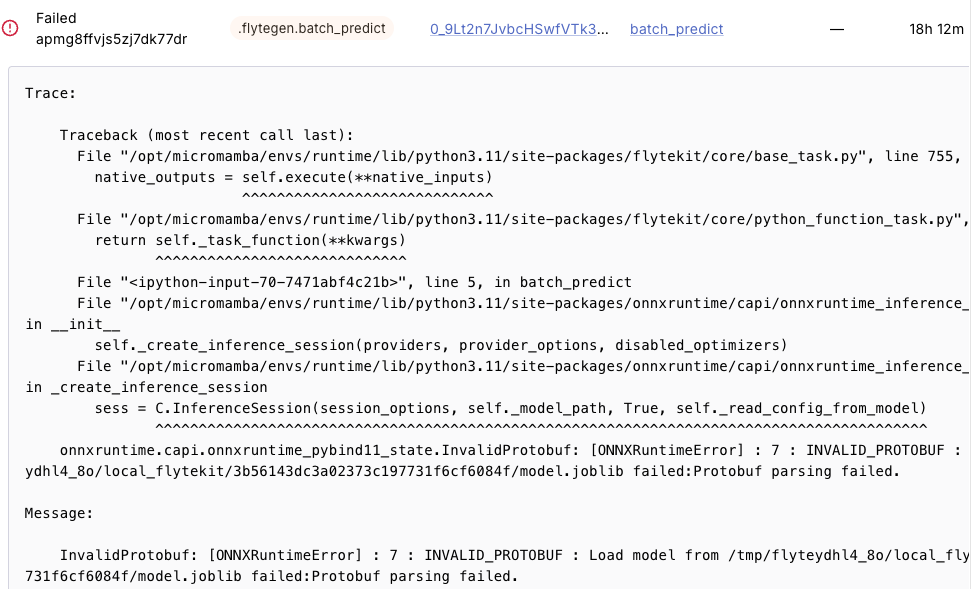

### Mitigation: include md5hash metadata

In [11]:
import hashlib
from dataclasses import dataclass


@dataclass
class Model:
    file: FlyteFile
    md5hash: str

    def __post_init__(self):
        with open(self.file, "rb") as f:
            md5hash = hashlib.md5(f.read()).hexdigest()
        if md5hash != self.md5hash:
            raise ValueError(
                "⛔️ Model md5hash mismatch: expected "
                f"{self.md5hash}, found {md5hash}."
            )

ModelOutput = NamedTuple("Output", [("model", Model), ("accuracy", float)])



@task
def secure_train_model(X_train: pd.DataFrame, y_train: pd.Series) -> Model:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    path = "model.joblib"
    joblib.dump(model, path)
    md5hash = hashlib.md5(open(path, 'rb').read()).hexdigest()
    return Model(file=FlyteFile(path=path), md5hash=md5hash)


@task(enable_deck=True)
def secure_evaluate_model(model: Model, X_test: pd.DataFrame, y_test: pd.Series) -> float:
    with open(model.file, "rb") as f:
        model = joblib.load(f)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    deck = union.Deck(name="Accuracy Report", html=MarkdownRenderer().to_html(f"# Test accuracy: {accuracy}"))
    union.current_context().decks.insert(0, deck)
    return accuracy


@union.workflow
def secure_wine_classification_workflow() -> ModelOutput:
    X, y = load_data()
    X_train, X_test, y_train, y_test = split_data(X, y)
    model = secure_train_model(X_train, y_train)
    accuracy = secure_evaluate_model(model, X_test, y_test)
    return model, accuracy

Run the secure training workflow:

In [12]:
execution = serverless.execute(secure_wine_classification_workflow, inputs={})
execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: axd95kvn742mdgdj72wn
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: secure_wine_classification_workflow
      version: jfzUTMJKmIrhAbAJGJ-cqA
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739898922
      nanos: 951089000
    updated_at:
      seconds: 1739898922
      nanos: 951089000

In [13]:
execution.wait(poll_interval=1)
model_file = execution.outputs["model"]

with open(model_file.file, "rb") as f:
    model = joblib.load(f)

print(f"md5hash: {model_file.md5hash}")
model

md5hash: b087efd0595a961982db5d35bce8a690


RandomForestClassifier(random_state=42)

Create a secure batch prediction workflow:

In [14]:
@union.task(container_image=image)
def model_guard(model: FlyteFile, md5hash: str) -> Model:
    return Model(file=model, md5hash=md5hash)


@union.task(container_image=image)
def secure_batch_predict(model: Model, data: pd.DataFrame) -> Predictions:
    with open(model.file, "rb") as f:
        model = joblib.load(f)
    return Predictions([float(x) for x in model.predict(data)])


@union.workflow
def secure_batch_prediction_workflow(
    model: FlyteFile,
    md5hash: str,
    data: pd.DataFrame
) -> Predictions:
    checked_model = model_guard(model, md5hash)
    return secure_batch_predict(checked_model, data)

Generate predictions with the correct model

In [15]:
execution = serverless.execute(
    secure_batch_prediction_workflow,
    inputs={
        "model": model_file.file,
        "md5hash": model_file.md5hash,
        "data": features
    }
)
execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: a7pw62kcw47d2k8hvnzz
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: secure_batch_prediction_workflow
      version: nAV3y_SpX79wKTrnLyVqIw
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739898992
      nanos: 119290000
    updated_at:
      seconds: 1739898992
      nanos: 119290000

In [16]:
execution.wait(poll_interval=1)
predictions = execution.outputs["predictions"]
predictions[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

Call the secure batch prediction workflow with the fake model

In [19]:
execution = serverless.execute(
    secure_batch_prediction_workflow,
    inputs={
        "model": fake_model_path,
        "md5hash": model_file.md5hash,
        "data": features
    }
)
execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: avlt75nw9c4cn22jmqt8
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: secure_batch_prediction_workflow
      version: nAV3y_SpX79wKTrnLyVqIw
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1739899049
      nanos: 289257000
    updated_at:
      seconds: 1739899049
      nanos: 289257000

## Part 2: ☣️ Data poisoning

In this section, we'll explore how to conduct an attack that flips labels on a fraction of the raw data and how to mitigate it using Pandera to check for statistical deviations

### Login to Union Serverless
If you haven't done so,  go to https://signup.union.ai/ to sign up for a Union account. This
will take a few minutes, after which you should be able to go to
https://serverless.union.ai/ to see the Union Serverless dashboard.

In [ ]:
!union create login --auth device-flow --serverless


Install local dependencies:

In [43]:
!pip install 'flytekit>=1.14.0' 'union==0.1.138' flytekitplugins-onnxscikitlearn flytekitplugins-pandera>=0.16.0 onnxruntime joblib openai pandas pyarrow scikit-learn numpy

Declare imports and remote dependencies:

In [48]:
import typing
import union
import flytekitplugins.pandera
import pandas as pd
import pandera as pa
from flytekit import ImageSpec, task, workflow
from pandera.typing import DataFrame, Index, Series
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from flytekit.types.file import ONNXFile
import onnxruntime as rt
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import numpy as np


custom_image = union.ImageSpec.from_env(
                   name="data-validation-lab",
                   packages=[
                       "flytekitplugins-pandera",
                       "scikit-learn",
                       "pyarrow",
                       "pandera",#new dependency
                       "pyspark",
                       "skl2onnx",
                       "onnxruntime",
                       "onnx",
                       "numpy",
                    ]
                )



### Specify statistical properties of the dataset

In [44]:
#---Encode the statistical properties of the data into a Pandera schema---#

class RawData(pa.DataFrameModel):
    age: Series[int] = pa.Field(in_range={"min_value": 0, "max_value": 200})
    sex: Series[int] = pa.Field(isin=[0, 1])
    cp: Series[int] = pa.Field(
        isin=[
            1,  # typical angina
            2,  # atypical angina
            3,  # non-anginal pain
            4,  # asymptomatic
        ]
    )
    trestbps: Series[int] = pa.Field(in_range={"min_value": 0, "max_value": 200})
    chol: Series[int] = pa.Field(in_range={"min_value": 0, "max_value": 600})
    fbs: Series[int] = pa.Field(isin=[0, 1])
    restecg: Series[int] = pa.Field(
        isin=[
            0,  # normal
            1,  # having ST-T wave abnormality
            2,  # showing probable or definite left ventricular hypertrophy by Estes' criteria
        ]
    )
    thalach: Series[int] = pa.Field(in_range={"min_value": 0, "max_value": 300})
    exang: Series[int] = pa.Field(isin=[0, 1])
    oldpeak: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 10})
    slope: Series[int] = pa.Field(
        isin=[
            1,  # upsloping
            2,  # flat
            3,  # downsloping
        ]
    )
    ca: Series[int] = pa.Field(isin=[0, 1, 2, 3])
    thal: Series[int] = pa.Field(
        isin=[
            3,  # normal
            6,  # fixed defect
            7,  # reversible defect
        ]
    )
    target: Series[int] = pa.Field(ge=0, le=4)

    class Config:
        coerce = True


Fetch the dataset:

In [45]:
@union.task(container_image=custom_image)
def fetch_raw_data() -> DataFrame[RawData]:
    print("fetching raw data")
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    return (
        pd.read_csv(data_url, header=None, names=RawData.to_schema().columns.keys())
        .replace({"ca": {"?": None}, "thal": {"?": None}})
        .dropna(subset=["ca", "thal"])
        .astype({"ca": float, "thal": float})
    )
data = fetch_raw_data()
data.head()

fetching raw data


15:38:19.226372 WARNING  deck.py:91 - Attempted to call publish() in task       
                         'local', but Flyte decks will not be generated because 
                         enable_deck is currently set to False.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


Parsing the raw data:

Converts the `target` column to a binary Series where `1` indicates the presence of heart disease (original values > 0) and `0` represents no heart disease. This collapses the multi-class UCI labels into a binary classification task."

In [30]:
class ParsedData(RawData):
    target: Series[int] = pa.Field(isin=[0, 1])

@union.task(container_image=custom_image)
def parse_raw_data(raw_data: DataFrame[RawData]) -> DataFrame[ParsedData]:
    return raw_data.assign(target=lambda _: (_.target > 0).astype(int))

### Register custom Pandera checks to detect statistical deviations:

In [31]:
#---Check fundamental medical relationships between features and target---#
class TrainingData(ParsedData):
    @pa.dataframe_check(error="Patients with heart disease should have higher average cholesterol")
    def validate_cholesterol(cls, df: pd.DataFrame) -> bool:
        healthy_chol = df[df.target == 0].chol.mean()
        disease_chol = df[df.target == 1].chol.mean()
        return disease_chol > healthy_chol

    @pa.dataframe_check(error="Patients with heart disease should not have lower max heart rate (thalach) on average")
    def validate_max_heart_rate(cls, df: pd.DataFrame) -> bool:
        healthy_thalach = df[df.target == 0].thalach.mean()
        disease_thalach = df[df.target == 1].thalach.mean()
        return disease_thalach < healthy_thalach

    @pa.dataframe_check(error="Exercise-induced angina is not more common in disease group")
    def validate_exercise_induced_angina(cls, df: pd.DataFrame) -> bool:
        exang_ratio = df[df.target == 1].exang.mean() / df[df.target == 0].exang.mean()
        return exang_ratio > 2.0

    @pa.dataframe_check
    def validate_feature_correlations(cls, df: pd.DataFrame) -> bool:
        """Ensure key feature correlations with target remain strong"""
        corrs = df.corr()['target'].abs()
        return all(corrs[['cp', 'exang', 'oldpeak']] > 0.3)  # These should be strongly correlated

### Data poisoning attack
If `poison_fraction > 0` it picks a random subset of size `len(poisoned) * poison_fraction` and flips the target labels from `1` to `0`, misguiding the model to classify a patient with the disease as healthy.

In [32]:
@union.task(container_image=custom_image)
def poison_training_data(
    training_set: DataFrame[ParsedData],
    poison_fraction: float,
    random_state: int
) -> DataFrame[TrainingData]:
    if poison_fraction <= 0:
        return training_set
    print("POISONING DATA")
    poisoned = training_set.copy()
    n_poison = int(len(poisoned) * poison_fraction)
    poisoned_indices = poisoned.sample(n=n_poison, random_state=random_state).index
    poisoned.loc[poisoned_indices, 'target'] = 1 - poisoned.loc[poisoned_indices, 'target']
    return poisoned

Splitting the data

In [33]:
DataSplits = typing.NamedTuple("DataSplits", training_set=DataFrame[ParsedData], test_set=DataFrame[ParsedData])


@union.task(container_image=custom_image)
def split_data(parsed_data: DataFrame[ParsedData], test_size: float, random_state: int) -> DataSplits:
    print("splitting data")
    training_set = parsed_data.sample(frac=test_size, random_state=random_state)
    test_set = parsed_data[~parsed_data.index.isin(training_set.index)]
    return training_set, test_set

Train the model:

In [34]:
def get_features_and_target(dataset):
    X = dataset[[x for x in dataset if x != "target"]]
    y = dataset["target"]
    return X, y

@union.task(container_image=custom_image)
def train_model(training_set: DataFrame[TrainingData], random_state: int) -> ONNXFile:
    # Pandera will validate TrainingData schema before execution
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    X, y = get_features_and_target(training_set)
    model.fit(X, y)
     # Convert to ONNX format
    initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]
    onnx_model = convert_sklearn(model, initial_types=initial_type)

    # Save ONNX model
    model_fp = "/tmp/model.onnx"
    with open(model_fp, "wb") as f:
        f.write(onnx_model.SerializeToString())

    return ONNXFile(path=model_fp)

Model evaluation:

In [35]:
@union.task(container_image=custom_image)
def evaluate_model(model: ONNXFile, test_set: DataFrame[ParsedData]) -> float:

    session = rt.InferenceSession(model.download())
    input_name = session.get_inputs()[0].name
    X, y = get_features_and_target(test_set)
    input_data = X.values.astype(np.float32)

    # Run inference
    preds = session.run(None, {input_name: input_data})[0]
    return accuracy_score(y, preds)

### Put everything together

In [36]:
@union.workflow
def pipeline(
    data_random_state: int = 42,
    model_random_state: int = 42,
    poison_fraction: float = 0.0,  # Default to no poisoning
    poison_random_state: int = 42
) -> float:
    raw_data = fetch_raw_data()
    parsed_data = parse_raw_data(raw_data=raw_data)
    poisoned_training_set = poison_training_data(
        training_set=parsed_data,
        poison_fraction=poison_fraction,
        random_state=poison_random_state
    )
    training_set, test_set = split_data(
        parsed_data=poisoned_training_set,
        test_size=0.2,
        random_state=data_random_state
    )
    model = train_model(
        training_set=training_set,
        random_state=model_random_state
    )
    return evaluate_model(model=model, test_set=test_set)


### Run the workflow locally with  poisoning
It should fail as Pandera detects deviations induced by poisoning

In [37]:
pipeline(poison_random_state=4, poison_fraction=0.2)

fetching raw data


15:30:40.986043 WARNING  deck.py:91 - Attempted to call publish() in task       
                         'local', but Flyte decks will not be generated because 
                         enable_deck is currently set to False.

15:30:41.056361 WARNING  deck.py:91 - Attempted to call publish() in task       
                         'local', but Flyte decks will not be generated because 
                         enable_deck is currently set to False.

POISONING DATA


15:30:41.180845 WARNING  deck.py:91 - Attempted to call publish() in task       
                         'local', but Flyte decks will not be generated because 
                         enable_deck is currently set to False.

╭─────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────╮
│ in <cell line: 0>:1                                                                                             │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/workflow.py:311 in __call__                               │
│                                                                                                                 │
│ ❱ 311 │   │   │   raise exc                                                                                     │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/workflow.py:304 in __call__                               │
│                                                                                                                 │
│ ❱ 304 │   │   │   return flyte_entity_call_handler(self, *args, **input_kwargs)                                 │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/promise.py:1533 in flyte_entity_call_handler              │
│                                                                                                                 │
│ ❱ 1533 │   │   │   result = cast(LocallyExecutable, entity).local_execute(child_ctx, **kwargs)                  │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/workflow.py:330 in local_execute                          │
│                                                                                                                 │
│ ❱ 330 │   │   function_outputs = self.execute(**kwargs_literals)                                                │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/workflow.py:847 in execute                                │
│                                                                                                                 │
│ ❱ 847 │   │   return self._workflow_function(**kwargs)                                                          │
│ in pipeline:10                                                                                                  │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/base_task.py:361 in __call__                              │
│                                                                                                                 │
│ ❱ 361 │   │   return flyte_entity_call_handler(self, *args, **kwargs)  # type: ignore                           │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/promise.py:1523 in flyte_entity_call_handler              │
│                                                                                                                 │
│ ❱ 1523 │   │   │   │   return cast(LocallyExecutable, entity).local_execute(ctx, **kwargs)                      │
│                                                                                                                 │
│ /usr/local/lib/python3.11/dist-packages/flytekit/core/base_task.py:341 in local_execute                         │
│                                                                                                                 │
│ ❱ 341 │   │   │   outputs_literal_map = self.sandbox_e

Run the workflow remotely without poisoning:

In [49]:
serverless = UnionRemote()
execution = serverless.execute(
    pipeline,
    inputs={} #no poisoning by default
)
execution

15:45:28.505063 WARNING  remote.py:293 - Jupyter notebook and interactive task  
                         support is still alpha.

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: andqgmrplr89qpt8zp4n
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: pipeline
      version: bFB33-N04MBLjzHynKyxNw
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1740066330
      nanos: 778747000
    updated_at:
      seconds: 1740066330
      nanos: 778747000

Retrieve the accuracy from the model's output:

In [50]:
execution.wait(poll_interval=1)
non_poisoned_accuracy = execution.outputs['o0']
print(non_poisoned_accuracy)

0.8067226890756303


### Trigger the attack

In [51]:
poisoned_execution = serverless.execute(
    pipeline,
    inputs={
        "poison_random_state": 102,
        "poison_fraction": 0.8,
    }
)
poisoned_execution

Flyte Serialized object (FlyteWorkflowExecution):
  id:
    project: default
    domain: development
    name: avq9vx64s97ww47xtwf8
  spec:
    launch_plan:
      resource_type: 3
      project: default
      domain: development
      name: pipeline
      version: bFB33-N04MBLjzHynKyxNw
    metadata:
      principal: 00uh8ip848eXOG2cq5d7
  closure:
    created_at:
      seconds: 1740066509
      nanos: 401419000
    updated_at:
      seconds: 1740066509
      nanos: 401419000

Check the model accuracy after poisoning (it should decrease):

In [52]:
poisoned_execution.wait(poll_interval=1)
poisoned_accuracy = poisoned_execution.outputs["o0"]
print(poisoned_accuracy)

0.6470588235294118




---



Congratulations 🎉! You've completed the workshop.

To summarize, you've learned the basic concepts, setup, and mitigations for
the pickled model attack and the data poisoning attack using Union together for data validation, code analysis and security.

## 🤔 Learn more

### Tools and Resources

- [Pandera](https://github.com/unionai-oss/pandera): data validation framework for Python
- [onnx](https://onnx.ai/): model serialization format for ML
- [safetensors](https://huggingface.co/docs/safetensors/en/index): model serialization library for PyTorch

You can learn more about Union at https://union.ai.

If you have any questions, please reach out to us at support@union.ai.

Thank you for attending!